In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import sys
import urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random_state = 100 # Ensure reproducible results

# DoWhy
import pygraphviz
from IPython.display import Image, display
import dowhy
from dowhy import CausalModel
import econml

# Generic ML imports
from scipy.stats import uniform, truncnorm, randint
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import meta_model_helpers as mmh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_burr.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [3]:
# DOCTOR DAG features
doc_features = ['age', 'stroke', 'ihd', 'metalvalve', 'antiplatelet', 'warfarin', 'hospital',
                'thickness_sum', 'density', 'optype', 'membranes', 'burrhole_num', 'bedrest',
                'drain', 'recurrence']

In [4]:
# Categorical type conversion
categorical_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'optype', 'recurrence',
                        'drain', 'hospital', 'bedrest', 'warfarin', 'density', 'membranes', 'burrhole_num',
                        'bedrest']

for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes


In [5]:
csdh_doc = csdh[doc_features]

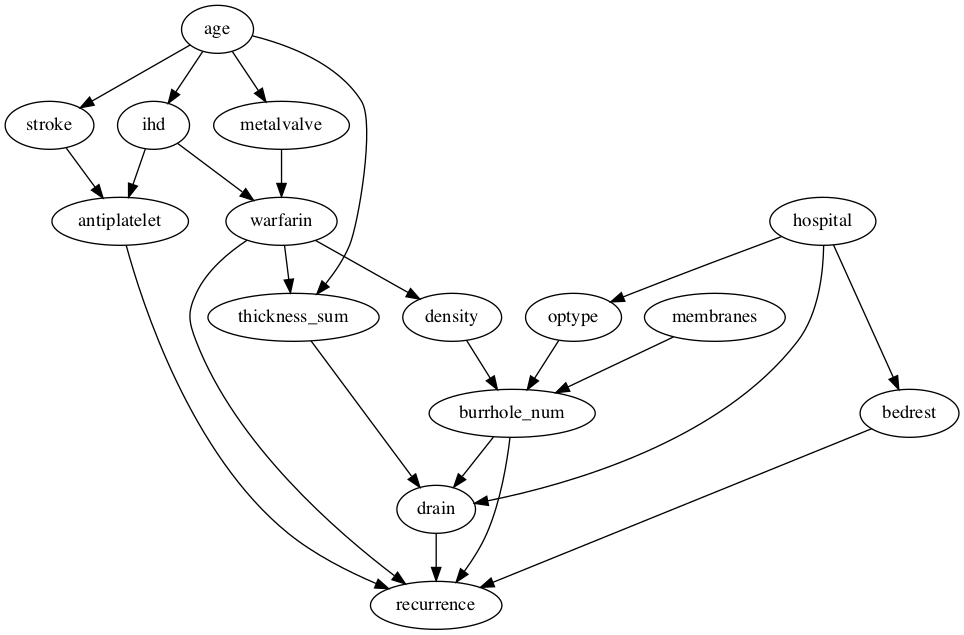

In [6]:
doc_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))
doc_model.view_model()
display(Image(filename="causal_model.png"))

---
## Define set of classifiers to investigate

In [7]:
names = ['Dummy', 'LR', 'Linear SVM', 'RBF SVM', 'GB', 'RF', 'XGB']

In [8]:
# Naive Bayes exluded due to mixture of variable types
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    LogisticRegression(max_iter=1000),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    XGBClassifier(random_state=random_state),
]

# _Double Machine Learning:_ finding `model_y` and `model_t`.
- `model_y` models $\mathbb{E}[Y \mid X,W]$ where the treatment variable $T$ is omitted from the covariates
- `model_t` is the propensity model and involves estimating $P[T=1\mid X,W]$

In [9]:
y_rec_full = csdh_doc['recurrence']
X_rec_full = csdh_doc.drop(['drain', 'recurrence'], axis=1)

In [10]:
# Split into validation set and rest
X_rec_rest, X_rec_val, y_rec_rest, y_rec_val = train_test_split(X_rec_full, y_rec_full, 
                                                                test_size=0.20,
                                                                random_state=random_state,
                                                                stratify=y_rec_full)

# Split rest into train and test set
X_rec_train, X_rec_test, y_rec_train, y_rec_test = train_test_split(X_rec_rest, y_rec_rest, 
                                                                    test_size=0.20,
                                                                    random_state=random_state,
                                                                    stratify=y_rec_rest)

In [11]:
rec_training_scores, rec_val_scores = mmh.train_and_validate_classifiers(X_rec_train, 
                                                                         y_rec_train,
                                                                         X_rec_val,
                                                                         y_rec_val,
                                                                         names,
                                                                         classifiers)

[16:34:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [12]:
mmh.print_metrics_table(rec_training_scores, rec_val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.916    0.500    0.000    0.000   2.902    0.911    0.500    0.000    0.000    3.090
LR            0.916    0.500    0.000    0.000   2.902    0.911    0.500    0.000    0.000    3.090
Linear SVM    0.916    0.500    0.000    0.000   2.902    0.911    0.500    0.000    0.000    3.090
RBF SVM       0.916    0.500    0.000    0.000   2.902    0.911    0.500    0.000    0.000    3.090
GB            0.866    0.518    0.100    0.111   4.644    0.968    0.824    0.647    0.786    1.091
RF            0.916    0.500    0.000    0.000   2.902    1.000    1.000    1.000    1.000    0.000
XGB           0.882    0.482    0.000    0.000 

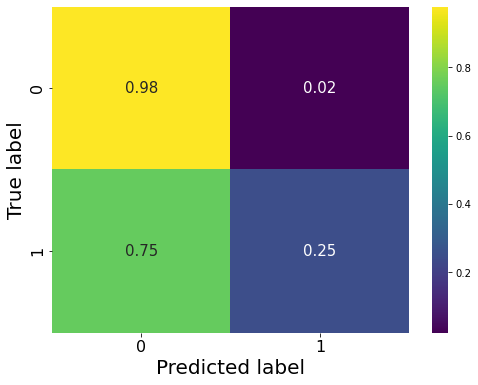

In [13]:
cm_rec_test = confusion_matrix(y_rec_test, classifiers[4].predict(X_rec_test), normalize='true')
mmh.plot_confusion_matrix(cm_rec_test, [0, 1])

## `model_y` K-Fold cross validation for hyperparameter tuning and model selection

In [14]:
# define cross-validation structure
cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

In [15]:
# define classifiers and hyperparameters to search over
rf = RandomForestClassifier()
params_rf = {
    # randomly sample numbers from 10 to 200 estimators
    'rf__n_estimators':randint(10, 200),
    
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'rf__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'rf__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators.
    
    'rf__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'rf__max_features':['sqrt', 'log2', None],
    # random seed
    'rf__random_state':[random_state],
    # Whether bootstrap samples are used when building trees
    'rf__bootstrap':[True, False]
}

gb = GradientBoostingClassifier()
params_gb = {
    # randomly sample numbers from 10 to 200 estimators
    'gb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'gb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'gb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1.0],
        
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'gb__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'gb__max_features':['sqrt', 'log2', None],
    # random seed
    'gb__random_state':[random_state]
}

xgb = XGBClassifier()
params_xgb = {
    # randomly sample numbers from 10 to 200 estimators
    'xgb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'xgb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'xgb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1],
    # min_split_loss
    'xgb__gamma':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3],
 
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'xgb__max_depth':randint(2, 15),
    # analagous to max_features in rf and gb
    'xgb__colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1],
    # random seed
    'xgb__random_state':[random_state],
}

In [16]:
# define search spaces for random search tuning
search_space = [('rf', rf, params_rf), ('gb', gb, params_gb), ('xgb', xgb, params_xgb)]

In [21]:
# do the search
_,_, best_estimator_rec = mmh.randomized_search_cv(X_rec_rest, y_rec_rest, 
                                                   search_space, 
                                                   cv=cv_10,
                                                   refit=True,
                                                   n_iter=5000, 
                                                   verbose=True)

cv strategy StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'xgb__n_estimators': 198, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=198,
                               n_jobs=None, num_parall

cv score: [0.73043478 0.3826087  0.47826087 0.63478261 0.69021739 0.66304348
 0.48913043 0.26086957 0.64673913 0.64130435]
----------------------------------------
Trial 11
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=81,
      

cv score: [0.59130435 0.26521739 0.63478261 0.42173913 0.80978261 0.60326087
 0.52173913 0.5326087  0.58152174 0.58695652]
----------------------------------------
Trial 20
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=91,
                                        random_state=100))])
cv score: [0.73913043 0.4        0.48695652 0.63043478 0.69565217 0.64673913
 0.47826087 0.29891304 0.6576087  0.64130435]
----------------------------------------
Trial 21
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCla

cv score: [0.71304348 0.41304348 0.50434783 0.55217391 0.64130435 0.51630435
 0.53804348 0.54891304 0.56521739 0.5923913 ]
----------------------------------------
Trial 31
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=89,
    

cv score: [0.80434783 0.43478261 0.40869565 0.5        0.5326087  0.51630435
 0.47826087 0.46195652 0.54891304 0.61956522]
----------------------------------------
Trial 40
----------------------------------------
Parameters {'rf__n_estimators': 29, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=29, random_state=100))])
cv score: [0.8        0.43043478 0.5173913  0.45217391 0.6576087  0.73369565
 0.48369565 0.49456522 0.58695652 0.5326087 ]
----------------------------------------
Trial 41
----------------------------------------
Parameters {'rf__n_estimators': 140, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                  

cv score: [0.67826087 0.38478261 0.5673913  0.46521739 0.63043478 0.55163043
 0.75815217 0.43206522 0.52717391 0.57880435]
----------------------------------------
Trial 50
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=128,
                                        random_state=100))])
cv score: [0.6173913  0.33043478 0.45217391 0.5        0.77173913 0.66847826
 0.44565217 0.33423913 0.66032609 0.56521739]
----------------------------------------
Trial 51
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipelin

cv score: [0.71086957 0.42826087 0.57608696 0.45434783 0.75       0.45380435
 0.6576087  0.32608696 0.5923913  0.60869565]
----------------------------------------
Trial 59
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=163,
      

cv score: [0.55434783 0.44347826 0.58695652 0.44782609 0.58967391 0.48369565
 0.64673913 0.45652174 0.61141304 0.59782609]
----------------------------------------
Trial 69
----------------------------------------
Parameters {'xgb__n_estimators': 42, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=42,
      

cv score: [0.55652174 0.48478261 0.61956522 0.80869565 0.41576087 0.44565217
 0.57608696 0.38043478 0.49184783 0.54891304]
----------------------------------------
Trial 79
----------------------------------------
Parameters {'gb__n_estimators': 163, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='log2',
                                            n_estimators=163, random_state=100,
                                            subsample=0.8))])
cv score: [0.61304348 0.43913043 0.4        0.55217391 0.66847826 0.60326087
 0.40217391 0.375      0.63586957 0.54891304]
----------------------------------------
Trial 80
----------------------------------------
Parameters {'gb__n_estimators': 141, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__

cv score: [0.76086957 0.44565217 0.59130435 0.40434783 0.70652174 0.52173913
 0.71195652 0.52173913 0.50543478 0.54619565]
----------------------------------------
Trial 88
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=108,
 

cv score: [0.46521739 0.3        0.50434783 0.57826087 0.73913043 0.45108696
 0.47282609 0.53804348 0.50543478 0.53804348]
----------------------------------------
Trial 97
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=170, random_state=100,
                                            subsample=0.8))])
cv score: [0.57826087 0.52173913 0.39565217 0.60434783 0.77173913 0.58152174
 0.45108696 0.47282609 0.61413043 0.5326087 ]
----------------------------------------
Trial 98
----------------------------------------
Parameters {'xgb__n_estimators': 149, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__

cv score: [0.42173913 0.46956522 0.46956522 0.47826087 0.80978261 0.30978261
 0.48369565 0.23369565 0.73369565 0.52717391]
----------------------------------------
Trial 108
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=75,
   

cv score: [0.58695652 0.43913043 0.43478261 0.55217391 0.60326087 0.56793478
 0.43478261 0.52717391 0.64673913 0.63043478]
----------------------------------------
Trial 118
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, n_estimators=37,
                                            random_state=100, subsample=0.7))])
cv score: [0.48695652 0.34347826 0.47826087 0.53913043 0.64673913 0.59782609
 0.40217391 0.22826087 0.73369565 0.5326087 ]
----------------------------------------
Trial 119
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
       

cv score: [0.67391304 0.47173913 0.61304348 0.47826087 0.72826087 0.59782609
 0.69293478 0.51358696 0.58695652 0.52173913]
----------------------------------------
Trial 127
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            n_estimators=28, random_state=100,
                                            subsample=0.8))])
cv score: [0.76956522 0.47826087 0.46521739 0.64347826 0.49184783 0.60326087
 0.60869565 0.36956522 0.67934783 0.55978261]
----------------------------------------
Trial 128
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pip

cv score: [0.57391304 0.3173913  0.63043478 0.5        0.80434783 0.57065217
 0.54891304 0.47282609 0.58152174 0.61956522]
----------------------------------------
Trial 138
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=127,
 

cv score: [0.21086957 0.5173913  0.40869565 0.64347826 0.32608696 0.57608696
 0.5923913  0.60326087 0.58152174 0.5       ]
----------------------------------------
Trial 149
----------------------------------------
Parameters {'gb__n_estimators': 122, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='sqrt',
                                            n_estimators=122, random_state=100,
                                            subsample=0.7))])
cv score: [0.63043478 0.49565217 0.49130435 0.59565217 0.77717391 0.58695652
 0.48913043 0.51086957 0.67391304 0.61956522]
----------------------------------------
Trial 150
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('

cv score: [0.63913043 0.47608696 0.56304348 0.43043478 0.72826087 0.45652174
 0.7201087  0.63315217 0.52445652 0.53804348]
----------------------------------------
Trial 161
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=101,
                                            random_state=100))])
cv score: [0.71086957 0.51086957 0.52173913 0.57391304 0.58967391 0.48369565
 0.52717391 0.63043478 0.56521739 0.64673913]
----------------------------------------
Trial 162
----------------------------------------
Parameters {'rf__n_estimators': 177, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 1

cv score: [0.67391304 0.45217391 0.49565217 0.53913043 0.67934783 0.5326087
 0.40217391 0.23369565 0.54891304 0.60326087]
----------------------------------------
Trial 173
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            n_estimators=128, random_state=100,
                                            subsample=0.6))])
cv score: [0.6173913  0.36521739 0.4        0.46086957 0.73369565 0.45652174
 0.42391304 0.27173913 0.70652174 0.50543478]
----------------------------------------
Trial 174
----------------------------------------
Parameters {'xgb__n_estimators': 88, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'x

cv score: [0.68695652 0.3173913  0.27826087 0.63043478 0.83152174 0.49456522
 0.41847826 0.44565217 0.54891304 0.5923913 ]
----------------------------------------
Trial 184
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=31,
                                        random_state=100))])
cv score: [0.62391304 0.22826087 0.55       0.77826087 0.4673913  0.32608696
 0.61684783 0.55434783 0.60326087 0.50271739]
----------------------------------------
Trial 185
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCla

cv score: [0.47391304 0.19130435 0.46956522 0.56956522 0.70108696 0.43478261
 0.5326087  0.60326087 0.48913043 0.60326087]
----------------------------------------
Trial 196
----------------------------------------
Parameters {'gb__n_estimators': 64, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
                                            n_estimators=64, random_state=100,
                                            subsample=0.65))])
cv score: [0.56521739 0.34347826 0.46956522 0.39565217 0.69565217 0.43478261
 0.48913043 0.24456522 0.60869565 0.61956522]
----------------------------------------
Trial 197
----------------------------------------
Parameters {'gb__n_estimators': 160, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}

cv score: [0.63913043 0.53913043 0.33913043 0.59130435 0.78804348 0.5923913
 0.5        0.5        0.60326087 0.60326087]
----------------------------------------
Trial 207
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            max_features='log2',
                                            n_estimators=34, random_state=100,
                                            subsample=0.8))])
cv score: [0.63043478 0.3173913  0.41304348 0.6826087  0.63043478 0.65217391
 0.44021739 0.22282609 0.51086957 0.5923913 ]
----------------------------------------
Trial 208
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_

cv score: [0.51304348 0.25217391 0.55652174 0.43043478 0.79347826 0.61413043
 0.5326087  0.42934783 0.60326087 0.58695652]
----------------------------------------
Trial 218
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='log2',
                                            n_estimators=128, random_state=100,
                                            subsample=0.85))])
cv score: [0.76521739 0.42608696 0.49130435 0.52608696 0.69021739 0.57608696
 0.51086957 0.47826087 0.66847826 0.57608696]
----------------------------------------
Trial 219
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__

cv score: [0.45217391 0.24782609 0.53478261 0.65217391 0.76630435 0.5326087
 0.52173913 0.49456522 0.54347826 0.59782609]
----------------------------------------
Trial 228
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='log2',
                                            n_estimators=117, random_state=100,
                                            subsample=0.9))])
cv score: [0.59130435 0.34782609 0.43043478 0.69130435 0.7173913  0.58695652
 0.39673913 0.44021739 0.5326087  0.61413043]
----------------------------------------
Trial 229
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=

cv score: [0.55217391 0.42173913 0.44347826 0.56086957 0.72826087 0.47826087
 0.45652174 0.26630435 0.74456522 0.60326087]
----------------------------------------
Trial 239
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=149, random_state=100,
                                            subsample=0.65))])
cv score: [0.58695652 0.4        0.37391304 0.53478261 0.67391304 0.64130435
 0.48913043 0.42934783 0.60869565 0.60869565]
----------------------------------------
Trial 240
----------------------------------------
Parameters {'gb__n_estimators': 13, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb_

cv score: [0.3826087  0.2        0.43043478 0.41304348 0.75       0.49456522
 0.2826087  0.63586957 0.57608696 0.48913043]
----------------------------------------
Trial 249
----------------------------------------
Parameters {'gb__n_estimators': 115, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=13,
                                            n_estimators=115, random_state=100,
                                            subsample=0.65))])
cv score: [0.46086957 0.3826087  0.60434783 0.43913043 0.57065217 0.52717391
 0.50543478 0.47826087 0.73913043 0.57065217]
----------------------------------------
Trial 250
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
P

cv score: [0.73478261 0.35652174 0.50434783 0.56086957 0.76630435 0.6576087
 0.45108696 0.32608696 0.60869565 0.5923913 ]
----------------------------------------
Trial 260
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=180,
     

cv score: [0.53913043 0.2173913  0.54347826 0.47391304 0.80978261 0.60326087
 0.46195652 0.47282609 0.57608696 0.54347826]
----------------------------------------
Trial 272
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            n_estimators=38, random_state=100,
                                            subsample=0.8))])
cv score: [0.52173913 0.4826087  0.40434783 0.45217391 0.52717391 0.43478261
 0.30978261 0.60869565 0.45652174 0.55434783]
----------------------------------------
Trial 273
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf

cv score: [0.61304348 0.41304348 0.58695652 0.69565217 0.42663043 0.33695652
 0.62228261 0.39402174 0.50543478 0.52445652]
----------------------------------------
Trial 282
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            max_features='log2',
                                            n_estimators=83, random_state=100,
                                            subsample=0.85))])
cv score: [0.73478261 0.41304348 0.49130435 0.56521739 0.7173913  0.54891304
 0.45652174 0.47826087 0.6576087  0.625     ]
----------------------------------------
Trial 283
----------------------------------------
Parameters {'rf__n_estimators': 172, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__r

cv score: [0.65217391 0.45217391 0.61086957 0.42173913 0.55163043 0.46195652
 0.69565217 0.38043478 0.56521739 0.63586957]
----------------------------------------
Trial 292
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=142,

cv score: [0.43043478 0.4173913  0.59565217 0.53913043 0.81521739 0.4673913
 0.45108696 0.58695652 0.4673913  0.67391304]
----------------------------------------
Trial 301
----------------------------------------
Parameters {'gb__n_estimators': 121, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='log2',
                                            n_estimators=121, random_state=100,
                                            subsample=0.8))])
cv score: [0.72608696 0.42608696 0.47391304 0.5173913  0.81521739 0.55434783
 0.4076087  0.625      0.5326087  0.6576087 ]
----------------------------------------
Trial 302
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
        

cv score: [0.65652174 0.66086957 0.39130435 0.6173913  0.7826087  0.39130435
 0.5        0.35326087 0.44565217 0.60869565]
----------------------------------------
Trial 311
----------------------------------------
Parameters {'gb__n_estimators': 79, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='sqrt',
                                            n_estimators=79, random_state=100,
                                            subsample=0.75))])
cv score: [0.57826087 0.5        0.43043478 0.62173913 0.69021739 0.61413043
 0.45652174 0.39673913 0.46195652 0.57608696]
----------------------------------------
Trial 312
----------------------------------------
Parameters {'xgb__n_estimators': 132, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8,

cv score: [0.46521739 0.43043478 0.44347826 0.47391304 0.69021739 0.60326087
 0.44565217 0.23913043 0.57608696 0.55434783]
----------------------------------------
Trial 321
----------------------------------------
Parameters {'gb__n_estimators': 175, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            n_estimators=175, random_state=100,
                                            subsample=0.6))])
cv score: [0.60869565 0.7826087  0.39130435 0.60434783 0.52717391 0.45380435
 0.25543478 0.40217391 0.49728261 0.59782609]
----------------------------------------
Trial 322
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',

cv score: [0.58478261 0.3326087  0.61086957 0.53913043 0.63586957 0.45108696
 0.58695652 0.52717391 0.63043478 0.63586957]
----------------------------------------
Trial 334
----------------------------------------
Parameters {'rf__n_estimators': 63, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=63, random_state=100))])
cv score: [0.72608696 0.42608696 0.44347826 0.56956522 0.66304348 0.63586957
 0.36956522 0.29347826 0.7173913  0.58152174]
----------------------------------------
Trial 335
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
               

cv score: [0.57826087 0.3826087  0.48695652 0.42608696 0.66304348 0.47826087
 0.44021739 0.25543478 0.77717391 0.57065217]
----------------------------------------
Trial 346
----------------------------------------
Parameters {'rf__n_estimators': 139, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=139, random_state=100))])
cv score: [0.80434783 0.44782609 0.51304348 0.49565217 0.60869565 0.58152174
 0.49456522 0.58695652 0.58152174 0.57608696]
----------------------------------------
Trial 347
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
               

cv score: [0.71304348 0.46086957 0.49130435 0.59130435 0.63586957 0.55978261
 0.51630435 0.60326087 0.55978261 0.64130435]
----------------------------------------
Trial 357
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=52,
      

cv score: [0.57826087 0.55652174 0.36086957 0.7173913  0.79347826 0.57065217
 0.41304348 0.42391304 0.50543478 0.5923913 ]
----------------------------------------
Trial 366
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=16,
                                        random_state=100))])
cv score: [0.61521739 0.41304348 0.57826087 0.50869565 0.45652174 0.36956522
 0.61413043 0.36956522 0.54619565 0.54891304]
----------------------------------------
Trial 367
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: 

cv score: [0.62608696 0.32173913 0.45217391 0.49565217 0.80434783 0.67391304
 0.44565217 0.25543478 0.6548913  0.58152174]
----------------------------------------
Trial 378
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=157,
  

cv score: [0.49565217 0.36086957 0.43043478 0.53043478 0.68478261 0.51630435
 0.38043478 0.53804348 0.51630435 0.58152174]
----------------------------------------
Trial 386
----------------------------------------
Parameters {'xgb__n_estimators': 129, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=129,


cv score: [0.62608696 0.55652174 0.46956522 0.79130435 0.48913043 0.625
 0.61956522 0.44021739 0.51630435 0.55978261]
----------------------------------------
Trial 397
----------------------------------------
Parameters {'gb__n_estimators': 10, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            n_estimators=10, random_state=100,
                                            subsample=0.95))])
cv score: [0.74130435 0.45869565 0.57391304 0.61521739 0.45380435 0.58695652
 0.63586957 0.30163043 0.67391304 0.69293478]
----------------------------------------
Trial 398
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__r

cv score: [0.61304348 0.37826087 0.46521739 0.52173913 0.75       0.51086957
 0.44565217 0.29891304 0.70108696 0.56521739]
----------------------------------------
Trial 406
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=81,
   

cv score: [0.6        0.3        0.55652174 0.62173913 0.67934783 0.54347826
 0.50543478 0.70652174 0.43478261 0.48913043]
----------------------------------------
Trial 415
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=104,
 

cv score: [0.49130435 0.36956522 0.4        0.58695652 0.77173913 0.47282609
 0.39673913 0.72826087 0.55434783 0.56521739]
----------------------------------------
Trial 425
----------------------------------------
Parameters {'xgb__n_estimators': 179, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=179,
  

cv score: [0.62608696 0.33478261 0.46956522 0.55652174 0.80434783 0.60869565
 0.47282609 0.38586957 0.625      0.60869565]
----------------------------------------
Trial 435
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=132, random_state=100))])
cv score: [0.8        0.45652174 0.47826087 0.46521739 0.60326087 0.58695652
 0.5        0.58152174 0.58152174 0.61413043]
----------------------------------------
Trial 436
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
               

cv score: [0.62173913 0.47391304 0.55217391 0.42608696 0.70380435 0.44565217
 0.77173913 0.4048913  0.52445652 0.63043478]
----------------------------------------
Trial 446
----------------------------------------
Parameters {'gb__n_estimators': 173, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                                            n_estimators=173, random_state=100,
                                            subsample=0.65))])
cv score: [0.73043478 0.47826087 0.36956522 0.5826087  0.77717391 0.66847826
 0.41304348 0.4076087  0.53804348 0.54891304]
----------------------------------------
Trial 447
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 1

cv score: [0.4        0.29130435 0.59565217 0.52173913 0.66847826 0.42391304
 0.38043478 0.65217391 0.72826087 0.63586957]
----------------------------------------
Trial 458
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=195,
                                        random_state=100))])
cv score: [0.75217391 0.44782609 0.4826087  0.59565217 0.61956522 0.47826087
 0.51630435 0.58152174 0.65217391 0.6576087 ]
----------------------------------------
Trial 459
----------------------------------------
Parameters {'rf__n_estimators': 123, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomFor

cv score: [0.51304348 0.36521739 0.43913043 0.45652174 0.67391304 0.42934783
 0.47282609 0.69565217 0.48369565 0.58695652]
----------------------------------------
Trial 468
----------------------------------------
Parameters {'xgb__n_estimators': 167, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=16

cv score: [0.68695652 0.63913043 0.4        0.67173913 0.54891304 0.42391304
 0.5        0.29891304 0.47826087 0.45108696]
----------------------------------------
Trial 476
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=32,
                                        random_state=100))])
cv score: [0.53043478 0.38695652 0.50434783 0.59130435 0.70108696 0.60869565
 0.49456522 0.35869565 0.69021739 0.72826087]
----------------------------------------
Trial 477
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
    

cv score: [0.60217391 0.45869565 0.59130435 0.45869565 0.38315217 0.52717391
 0.66304348 0.48913043 0.58152174 0.61956522]
----------------------------------------
Trial 486
----------------------------------------
Parameters {'rf__n_estimators': 13, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=13,
                                        random_state=100))])
cv score: [0.77608696 0.44130435 0.3826087  0.5173913  0.57608696 0.48913043
 0.56793478 0.47826087 0.52717391 0.59782609]
----------------------------------------
Trial 487
----------------------------------------
Parameters {'rf__n_estimators': 133, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCl

cv score: [0.60217391 0.41304348 0.57826087 0.50869565 0.45652174 0.36956522
 0.61413043 0.36956522 0.54619565 0.54891304]
----------------------------------------
Trial 497
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            n_estimators=43, random_state=100,
                                            subsample=0.7))])
cv score: [0.63478261 0.37826087 0.51304348 0.64347826 0.54347826 0.51630435
 0.36413043 0.33695652 0.66847826 0.55978261]
----------------------------------------
Trial 498
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeli

cv score: [0.6        0.40869565 0.4173913  0.6        0.73913043 0.5923913
 0.45108696 0.375      0.52717391 0.49456522]
----------------------------------------
Trial 506
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=160,
   

cv score: [0.4173913  0.36086957 0.33913043 0.50869565 0.70108696 0.49456522
 0.5        0.54347826 0.58152174 0.49456522]
----------------------------------------
Trial 516
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=113,
                                        random_state=100))])
cv score: [0.57826087 0.38043478 0.58695652 0.7173913  0.42934783 0.44565217
 0.60054348 0.38043478 0.50543478 0.52445652]
----------------------------------------
Trial 517
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: 

cv score: [0.56956522 0.30869565 0.56086957 0.55652174 0.73913043 0.42934783
 0.33695652 0.59782609 0.45652174 0.63586957]
----------------------------------------
Trial 524
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=195,
                                        random_state=100))])
cv score: [0.56521739 0.2826087  0.43043478 0.49565217 0.79347826 0.64673913
 0.44565217 0.37228261 0.66847826 0.55978261]
----------------------------------------
Trial 525
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',


cv score: [0.62173913 0.44347826 0.4173913  0.5        0.68478261 0.6576087
 0.45652174 0.36956522 0.63586957 0.5923913 ]
----------------------------------------
Trial 536
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=178,
 

cv score: [0.50434783 0.23478261 0.64347826 0.56521739 0.66304348 0.4076087
 0.48913043 0.69021739 0.50543478 0.57608696]
----------------------------------------
Trial 545
----------------------------------------
Parameters {'xgb__n_estimators': 17, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=17,
  

cv score: [0.68695652 0.34347826 0.46086957 0.58695652 0.77717391 0.61413043
 0.46195652 0.32608696 0.67391304 0.5923913 ]
----------------------------------------
Trial 554
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            n_estimators=148, random_state=100,
                                            subsample=0.95))])
cv score: [0.69565217 0.42173913 0.47826087 0.61304348 0.65217391 0.56521739
 0.63043478 0.29347826 0.70652174 0.63043478]
----------------------------------------
Trial 555
----------------------------------------
Parameters {'rf__n_estimators': 24, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[

cv score: [0.45652174 0.2826087  0.6173913  0.53478261 0.77173913 0.5326087
 0.52717391 0.50543478 0.58695652 0.5923913 ]
----------------------------------------
Trial 565
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=14, random_state=100,
                                            subsample=0.75))])
cv score: [0.27826087 0.4826087  0.49130435 0.39565217 0.66847826 0.61413043
 0.58152174 0.39673913 0.58152174 0.39130435]
----------------------------------------
Trial 566
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'x

cv score: [0.67826087 0.46086957 0.57608696 0.44347826 0.72282609 0.50815217
 0.68478261 0.44021739 0.5326087  0.54076087]
----------------------------------------
Trial 574
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=33, random_state=100))])
cv score: [0.52608696 0.46086957 0.44782609 0.49130435 0.43478261 0.67663043
 0.41032609 0.28804348 0.61413043 0.5923913 ]
----------------------------------------
Trial 575
----------------------------------------
Parameters {'gb__n_estimators': 198, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate

cv score: [0.57391304 0.53913043 0.42173913 0.6        0.79347826 0.44565217
 0.47282609 0.50543478 0.2826087  0.5       ]
----------------------------------------
Trial 585
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=183,
                                        random_state=100))])
cv score: [0.66086957 0.38913043 0.57608696 0.73043478 0.45108696 0.57608696
 0.47282609 0.30706522 0.57608696 0.65217391]
----------------------------------------
Trial 586
----------------------------------------
Parameters {'rf__n_estimators': 101, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCl

cv score: [0.76956522 0.42608696 0.50434783 0.57826087 0.77173913 0.50543478
 0.49456522 0.53804348 0.65217391 0.64130435]
----------------------------------------
Trial 595
----------------------------------------
Parameters {'gb__n_estimators': 50, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='log2',
                                            n_estimators=50, random_state=100,
                                            subsample=0.95))])
cv score: [0.73478261 0.44782609 0.5173913  0.6173913  0.77717391 0.67934783
 0.51086957 0.4076087  0.5326087  0.6576087 ]
----------------------------------------
Trial 596
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random

cv score: [0.47391304 0.30434783 0.56086957 0.5        0.69565217 0.58695652
 0.52173913 0.39130435 0.59782609 0.625     ]
----------------------------------------
Trial 607
----------------------------------------
Parameters {'xgb__n_estimators': 62, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=62,
   

cv score: [0.70434783 0.42173913 0.46521739 0.4173913  0.75       0.61413043
 0.47826087 0.45652174 0.61956522 0.66304348]
----------------------------------------
Trial 615
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=14, random_state=100))])
cv score: [0.88695652 0.3173913  0.5826087  0.57826087 0.625      0.51630435
 0.46195652 0.35869565 0.77717391 0.5326087 ]
----------------------------------------
Trial 616
----------------------------------------
Parameters {'xgb__n_estimators': 58, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_s

cv score: [0.43043478 0.3        0.56086957 0.53043478 0.70108696 0.47282609
 0.52717391 0.47826087 0.53804348 0.64130435]
----------------------------------------
Trial 626
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=195, random_state=100))])
cv score: [0.52608696 0.36086957 0.49782609 0.43043478 0.6576087  0.44021739
 0.46467391 0.35326087 0.7201087  0.60326087]
----------------------------------------
Trial 627
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001

cv score: [0.62608696 0.44782609 0.38695652 0.55217391 0.73913043 0.74456522
 0.45652174 0.3423913  0.59782609 0.59782609]
----------------------------------------
Trial 637
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=130,
   

cv score: [0.62173913 0.34347826 0.61304348 0.42608696 0.78804348 0.57608696
 0.36956522 0.53804348 0.57608696 0.53804348]
----------------------------------------
Trial 645
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=176, random_state=100,
                                            subsample=0.85))])
cv score: [0.72173913 0.4173913  0.37391304 0.53043478 0.70652174 0.63043478
 0.47282609 0.44565217 0.6576087  0.56521739]
----------------------------------------
Trial 646
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__m

cv score: [0.62173913 0.29130435 0.57391304 0.52608696 0.71195652 0.5923913
 0.47826087 0.57065217 0.57608696 0.56521739]
----------------------------------------
Trial 656
----------------------------------------
Parameters {'xgb__n_estimators': 56, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=56,
    

cv score: [0.67391304 0.42608696 0.56956522 0.44782609 0.7173913  0.4673913
 0.6875     0.38315217 0.58967391 0.57336957]
----------------------------------------
Trial 665
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=171,
                                        random_state=100))])
cv score: [0.58695652 0.42826087 0.48695652 0.55217391 0.41847826 0.57880435
 0.54347826 0.42663043 0.7173913  0.49456522]
----------------------------------------
Trial 666
----------------------------------------
Parameters {'gb__n_estimators': 32, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
      

cv score: [0.56521739 0.2826087  0.52608696 0.53913043 0.70108696 0.56521739
 0.51630435 0.47826087 0.61413043 0.5326087 ]
----------------------------------------
Trial 675
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=163,
 

cv score: [0.61304348 0.3        0.43913043 0.43043478 0.75543478 0.55978261
 0.41304348 0.73369565 0.45108696 0.60326087]
----------------------------------------
Trial 683
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=182,
                                        random_state=100))])
cv score: [0.67391304 0.34347826 0.45217391 0.57391304 0.78804348 0.61413043
 0.46195652 0.33152174 0.67934783 0.58695652]
----------------------------------------
Trial 684
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb'

cv score: [0.72608696 0.38913043 0.59130435 0.48913043 0.72282609 0.52173913
 0.63586957 0.42391304 0.58695652 0.58695652]
----------------------------------------
Trial 693
----------------------------------------
Parameters {'gb__n_estimators': 194, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, n_estimators=194,
                                            random_state=100, subsample=0.8))])
cv score: [0.54347826 0.4        0.46956522 0.43478261 0.77173913 0.45108696
 0.47826087 0.375      0.76630435 0.49456522]
----------------------------------------
Trial 694
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max

cv score: [0.74782609 0.39347826 0.6173913  0.4826087  0.72282609 0.51086957
 0.63043478 0.51630435 0.61956522 0.51630435]
----------------------------------------
Trial 706
----------------------------------------
Parameters {'gb__n_estimators': 136, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            max_features='log2',
                                            n_estimators=136, random_state=100,
                                            subsample=0.6))])
cv score: [0.57826087 0.64347826 0.52173913 0.52608696 0.64130435 0.75543478
 0.47282609 0.8423913  0.625      0.38586957]
----------------------------------------
Trial 707
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_

cv score: [0.6173913  0.44782609 0.55652174 0.53043478 0.81521739 0.5
 0.35326087 0.65217391 0.60326087 0.66847826]
----------------------------------------
Trial 717
----------------------------------------
Parameters {'gb__n_estimators': 85, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='log2',
                                            n_estimators=85, random_state=100,
                                            subsample=0.75))])
cv score: [0.56956522 0.40869565 0.43043478 0.63913043 0.51086957 0.77173913
 0.61956522 0.5923913  0.54891304 0.45652174]
----------------------------------------
Trial 718
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state'

cv score: [0.60652174 0.49347826 0.6        0.42173913 0.58967391 0.45108696
 0.60054348 0.45652174 0.5        0.47826087]
----------------------------------------
Trial 730
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=144, random_state=100))])
cv score: [0.50869565 0.33913043 0.48695652 0.43913043 0.63586957 0.4673913
 0.45652174 0.32608696 0.71195652 0.61413043]
----------------------------------------
Trial 731
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                    

cv score: [0.67173913 0.44130435 0.57391304 0.43043478 0.76630435 0.53804348
 0.70380435 0.3451087  0.52173913 0.56521739]
----------------------------------------
Trial 742
----------------------------------------
Parameters {'gb__n_estimators': 173, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                            max_features='log2',
                                            n_estimators=173,
                                            random_state=100))])
cv score: [0.58695652 0.54782609 0.42608696 0.63043478 0.73913043 0.69021739
 0.47282609 0.57065217 0.56521739 0.45652174]
----------------------------------------
Trial 743
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 

cv score: [0.7173913  0.63043478 0.6        0.47826087 0.73913043 0.58152174
 0.61413043 0.46467391 0.5        0.55434783]
----------------------------------------
Trial 753
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=105,

cv score: [0.66086957 0.4173913  0.51304348 0.56521739 0.58152174 0.58695652
 0.55978261 0.57065217 0.54347826 0.58152174]
----------------------------------------
Trial 763
----------------------------------------
Parameters {'rf__n_estimators': 78, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=78,
                                        random_state=100))])
cv score: [0.74347826 0.49130435 0.50869565 0.56956522 0.67391304 0.49456522
 0.51630435 0.40217391 0.66304348 0.6576087 ]
----------------------------------------
Trial 764
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestC

cv score: [0.60869565 0.41304348 0.63695652 0.42608696 0.67391304 0.47826087
 0.64945652 0.36413043 0.57065217 0.60054348]
----------------------------------------
Trial 772
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            n_estimators=126,
                                            random_state=100))])
cv score: [0.53043478 0.28695652 0.47826087 0.55217391 0.63043478 0.42391304
 0.44021739 0.48913043 0.50543478 0.67391304]
----------------------------------------
Trial 773
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_sta

cv score: [0.66956522 0.33478261 0.44782609 0.57391304 0.79347826 0.61413043
 0.45652174 0.32608696 0.67934783 0.5923913 ]
----------------------------------------
Trial 781
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=152, random_state=100))])
cv score: [0.6826087  0.46521739 0.45652174 0.47391304 0.72282609 0.70652174
 0.45108696 0.33152174 0.59782609 0.5326087 ]
----------------------------------------
Trial 782
----------------------------------------
Parameters {'xgb__n_estimators': 100, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassi

cv score: [0.62608696 0.30434783 0.56086957 0.40869565 0.8423913  0.42391304
 0.64130435 0.44565217 0.66847826 0.55978261]
----------------------------------------
Trial 791
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=62, random_state=100,
                                            subsample=0.9))])
cv score: [0.6826087  0.4        0.42608696 0.56956522 0.70108696 0.625
 0.42391304 0.3423913  0.66304348 0.53804348]
----------------------------------------
Trial 792
----------------------------------------
Parameters {'rf__n_estimators': 63, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_s

cv score: [0.45217391 0.25217391 0.52173913 0.55652174 0.67391304 0.54347826
 0.48913043 0.66847826 0.4673913  0.50543478]
----------------------------------------
Trial 802
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=101,


cv score: [0.65434783 0.47173913 0.59782609 0.50869565 0.68206522 0.45652174
 0.71467391 0.28804348 0.50271739 0.5923913 ]
----------------------------------------
Trial 813
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=96, random_state=100,
                                            subsample=0.75))])
cv score: [0.70434783 0.43478261 0.41304348 0.5826087  0.67934783 0.74456522
 0.49456522 0.32608696 0.66847826 0.57608696]
----------------------------------------
Trial 814
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__ran

cv score: [0.74782609 0.4673913  0.5673913  0.59565217 0.52717391 0.48641304
 0.7173913  0.52717391 0.59782609 0.60054348]
----------------------------------------
Trial 821
----------------------------------------
Parameters {'gb__n_estimators': 50, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=50, random_state=100,
                                            subsample=0.95))])
cv score: [0.73043478 0.44782609 0.34782609 0.7        0.84782609 0.63043478
 0.4076087  0.78804348 0.27173913 0.5326087 ]
----------------------------------------
Trial 822
----------------------------------------
Parameters {'rf__n_estimators': 172, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random

cv score: [0.46521739 0.41304348 0.35652174 0.57391304 0.5923913  0.43478261
 0.2173913  0.48369565 0.64673913 0.55434783]
----------------------------------------
Trial 832
----------------------------------------
Parameters {'xgb__n_estimators': 71, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=71,
       

cv score: [0.43043478 0.33478261 0.59130435 0.59130435 0.79347826 0.47282609
 0.47826087 0.375      0.43478261 0.56521739]
----------------------------------------
Trial 841
----------------------------------------
Parameters {'gb__n_estimators': 44, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, n_estimators=44,
                                            random_state=100, subsample=0.9))])
cv score: [0.57391304 0.3        0.50434783 0.54347826 0.67391304 0.5326087
 0.57065217 0.32065217 0.60869565 0.60326087]
----------------------------------------
Trial 842
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassi

cv score: [0.50869565 0.3        0.6173913  0.48695652 0.81521739 0.52173913
 0.54891304 0.48369565 0.63586957 0.63586957]
----------------------------------------
Trial 852
----------------------------------------
Parameters {'gb__n_estimators': 18, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=18, random_state=100,
                                            subsample=0.85))])
cv score: [0.43478261 0.29130435 0.3826087  0.70434783 0.55978261 0.625
 0.43478261 0.30978261 0.64673913 0.59782609]
----------------------------------------
Trial 853
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__

cv score: [0.66956522 0.39130435 0.49130435 0.42608696 0.73369565 0.66304348
 0.45652174 0.42934783 0.64130435 0.625     ]
----------------------------------------
Trial 861
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=76,
       

cv score: [0.47391304 0.26956522 0.54782609 0.44347826 0.63043478 0.5326087
 0.32065217 0.64130435 0.54347826 0.45108696]
----------------------------------------
Trial 870
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=93,
      

cv score: [0.64782609 0.44347826 0.40434783 0.5173913  0.7173913  0.69565217
 0.44021739 0.41847826 0.5923913  0.52717391]
----------------------------------------
Trial 878
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            n_estimators=34, random_state=100,
                                            subsample=0.75))])
cv score: [0.80434783 0.37826087 0.46956522 0.59565217 0.57065217 0.60869565
 0.55978261 0.26086957 0.61956522 0.54891304]
----------------------------------------
Trial 879
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('

cv score: [0.65652174 0.34782609 0.46521739 0.53913043 0.625      0.50543478
 0.48369565 0.35326087 0.75       0.59782609]
----------------------------------------
Trial 891
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=152,
                                        random_state=100))])
cv score: [0.76086957 0.42608696 0.4826087  0.64347826 0.73913043 0.61413043
 0.46195652 0.32608696 0.67391304 0.63043478]
----------------------------------------
Trial 892
----------------------------------------
Parameters {'xgb__n_estimators': 181, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipe

cv score: [0.49130435 0.30434783 0.68695652 0.49565217 0.77173913 0.50543478
 0.57608696 0.49456522 0.66847826 0.51630435]
----------------------------------------
Trial 899
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=197, random_state=100,
                                            subsample=0.95))])
cv score: [0.69130435 0.36521739 0.43478261 0.6        0.75543478 0.60869565
 0.4673913  0.36956522 0.63043478 0.56521739]
----------------------------------------
Trial 900
----------------------------------------
Parameters {'gb__n_estimators': 61, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__ma

cv score: [0.43695652 0.53043478 0.22826087 0.54347826 0.63043478 0.57065217
 0.52445652 0.4673913  0.47282609 0.86413043]
----------------------------------------
Trial 910
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, max_features='log2',
                                            n_estimators=125, random_state=100,
                                            subsample=0.7))])
cv score: [0.62173913 0.5826087  0.4        0.66956522 0.67934783 0.66304348
 0.44021739 0.42391304 0.625      0.58695652]
----------------------------------------
Trial 911
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=

cv score: [0.57391304 0.5826087  0.54782609 0.64347826 0.57608696 0.7173913
 0.31521739 0.2826087  0.49456522 0.66304348]
----------------------------------------
Trial 920
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=129, random_state=100,
                                            subsample=0.85))])
cv score: [0.55652174 0.53043478 0.42608696 0.59565217 0.83695652 0.68478261
 0.39673913 0.52717391 0.54347826 0.60869565]
----------------------------------------
Trial 921
----------------------------------------
Parameters {'xgb__n_estimators': 197, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb

cv score: [0.65652174 0.5        0.58478261 0.50434783 0.74456522 0.54347826
 0.78804348 0.48641304 0.51358696 0.5298913 ]
----------------------------------------
Trial 930
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=104, random_state=100))])
cv score: [0.86521739 0.42608696 0.50434783 0.55652174 0.66304348 0.63586957
 0.53804348 0.55978261 0.625      0.57065217]
----------------------------------------
Trial 931
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                

cv score: [0.52608696 0.2826087  0.52173913 0.5        0.76630435 0.51630435
 0.56521739 0.4673913  0.58695652 0.57065217]
----------------------------------------
Trial 940
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=112,
       

cv score: [0.7173913  0.47391304 0.58913043 0.5173913  0.73369565 0.46195652
 0.61413043 0.6576087  0.50543478 0.60326087]
----------------------------------------
Trial 949
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=165,
  

cv score: [0.57826087 0.4        0.49565217 0.4173913  0.64673913 0.46195652
 0.46195652 0.34782609 0.73369565 0.59782609]
----------------------------------------
Trial 957
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=106, random_state=100))])
cv score: [0.86086957 0.4173913  0.50434783 0.55652174 0.66304348 0.64673913
 0.53804348 0.55978261 0.625      0.58152174]
----------------------------------------
Trial 958
----------------------------------------
Parameters {'rf__n_estimators': 127, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
            

cv score: [0.72173913 0.44347826 0.50869565 0.62173913 0.64673913 0.49456522
 0.54347826 0.56521739 0.63586957 0.625     ]
----------------------------------------
Trial 966
----------------------------------------
Parameters {'rf__n_estimators': 161, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=161, random_state=100))])
cv score: [0.59565217 0.39565217 0.49130435 0.41304348 0.64673913 0.47826087
 0.45652174 0.3423913  0.72282609 0.5923913 ]
----------------------------------------
Trial 967
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,

cv score: [0.60869565 0.47608696 0.5173913  0.5173913  0.67663043 0.49728261
 0.68206522 0.51630435 0.51358696 0.47282609]
----------------------------------------
Trial 977
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=48,
     

cv score: [0.40869565 0.28695652 0.51304348 0.51304348 0.73369565 0.5
 0.52173913 0.4673913  0.47826087 0.47282609]
----------------------------------------
Trial 985
----------------------------------------
Parameters {'rf__n_estimators': 140, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=140, random_state=100))])
cv score: [0.74782609 0.43478261 0.5173913  0.4826087  0.73913043 0.54891304
 0.45652174 0.4673913  0.63586957 0.54891304]
----------------------------------------
Trial 986
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,

cv score: [0.66956522 0.32608696 0.56521739 0.56956522 0.72826087 0.58695652
 0.36956522 0.51086957 0.60326087 0.46195652]
----------------------------------------
Trial 996
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=78,
       

In [22]:
mmh.get_test_scores(X_rec_rest, y_rec_rest, X_rec_test, y_rec_test, best_estimator_rec)

Performance on the test set
Classification accuracy: 0.9078947368421053
AUROC: 0.5
Recall: 0.0
F1 Score: 0.0
Log-loss: 3.181203089004932


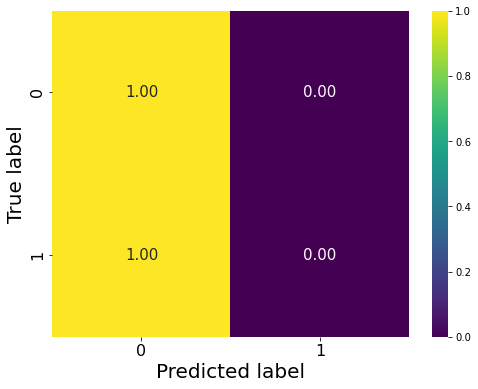

In [23]:
cm_rec_test = confusion_matrix(y_rec_test, best_estimator_rec.predict(X_rec_test), normalize='true')
mmh.plot_confusion_matrix(cm_rec_test, [0, 1])

---
## Predicting $T$ (drain) from controls $X, W$

In [24]:
y_drain_full = csdh_doc['drain']
X_drain_full = csdh_doc.drop(['drain', 'recurrence'], axis=1)

In [25]:
# Split into validation set and rest
X_drain_rest, X_drain_val, y_drain_rest, y_drain_val = train_test_split(X_drain_full, y_drain_full, 
                                                                        test_size=0.20,
                                                                        random_state=random_state,
                                                                        stratify=y_drain_full)

# Split rest into train and test set
X_drain_train, X_drain_test, y_drain_train, y_drain_test = train_test_split(X_drain_rest, y_drain_rest, 
                                                                            test_size=0.20,
                                                                            random_state=random_state,
                                                                            stratify=y_drain_rest)

In [26]:
drain_training_scores, drain_val_scores = mmh.train_and_validate_classifiers(X_drain_train, 
                                                                             y_drain_train,
                                                                             X_drain_val,
                                                                             y_drain_val,
                                                                             names,
                                                                             classifiers)

[13:56:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
mmh.print_metrics_table(drain_training_scores, drain_val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.844    0.500    1.000    0.916   5.373    0.839    0.500    1.000    0.912    5.568
LR            0.844    0.500    1.000    0.916   5.373    0.846    0.522    1.000    0.916    5.326
Linear SVM    0.844    0.500    1.000    0.916   5.373    0.839    0.500    1.000    0.912    5.568
RBF SVM       0.844    0.500    1.000    0.916   5.373    0.839    0.500    1.000    0.912    5.568
GB            0.800    0.503    0.934    0.888   6.908    0.956    0.874    0.994    0.974    1.533
RF            0.844    0.500    1.000    0.916   5.373    1.000    1.000    1.000    1.000    0.000
XGB           0.767    0.512    0.882    0.865 

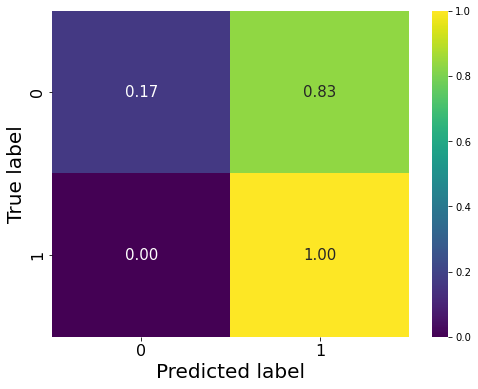

In [28]:
cm_drain_test = confusion_matrix(y_drain_test, classifiers[5].predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])

## `model_t` K-Fold cross validation for hyperparameter tuning and model selection

In [30]:
# do the search
_,_, best_estimator_drain = mmh.randomized_search_cv(X_drain_rest, y_drain_rest, 
                                                     search_space, 
                                                     cv=cv_10,
                                                     refit=True,
                                                     score='roc_auc',
                                                     n_iter=5000, 
                                                     verbose=True)

cv strategy StratifiedKFold(n_splits=10, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=41, random_state=100))])
cv score: [0.88081395 0.75436047 0.65843023 0.66666667 0.75892857 0.5922619
 0.79017857 0.80952381 0.60714286 0.61904762]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'xgb__n_estimators': 23, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               

cv score: [0.93604651 0.8255814  0.75290698 0.78571429 0.9047619  0.91369048
 0.83333333 0.86607143 0.84821429 0.72619048]
----------------------------------------
Trial 10
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=41, random_state=100))])
cv score: [0.91860465 0.77906977 0.68313953 0.78571429 0.82440476 0.79761905
 0.76190476 0.79166667 0.80059524 0.60714286]
----------------------------------------
Trial 11
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,

cv score: [0.85755814 0.74418605 0.68895349 0.71428571 0.85714286 0.81547619
 0.79761905 0.83035714 0.75595238 0.58630952]
----------------------------------------
Trial 21
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=44,
                                        random_state=100))])
cv score: [0.85901163 0.74709302 0.63517442 0.71957672 0.79166667 0.72619048
 0.75       0.81547619 0.78571429 0.58928571]
----------------------------------------
Trial 22
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: P

cv score: [0.87790698 0.80523256 0.65406977 0.73280423 0.85416667 0.89583333
 0.85714286 0.81547619 0.7797619  0.625     ]
----------------------------------------
Trial 29
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=113, random_state=100))])
cv score: [0.86046512 0.74418605 0.64534884 0.73809524 0.85714286 0.86904762
 0.86309524 0.79464286 0.78869048 0.63690476]
----------------------------------------
Trial 30
----------------------------------------
Parameters {'gb__n_estimators': 103, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.0

cv score: [0.81976744 0.81976744 0.74418605 0.75661376 0.92559524 0.83333333
 0.67559524 0.79166667 0.68452381 0.60119048]
----------------------------------------
Trial 39
----------------------------------------
Parameters {'rf__n_estimators': 180, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=180,
                                        random_state=100))])
cv score: [0.84447674 0.72383721 0.64534884 0.8042328  0.81547619 0.84375
 0.72321429 0.78571429 0.73363095 0.69940476]
----------------------------------------
Trial 40
----------------------------------------
Parameters {'gb__n_estimators': 44, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.94186047 0.7877907  0.75290698 0.75132275 0.9077381  0.91666667
 0.77678571 0.85416667 0.78869048 0.61309524]
----------------------------------------
Trial 49
----------------------------------------
Parameters {'xgb__n_estimators': 25, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=25,
      

cv score: [0.92732558 0.80523256 0.69767442 0.81746032 0.88690476 0.91666667
 0.81547619 0.86607143 0.83630952 0.6875    ]
----------------------------------------
Trial 59
----------------------------------------
Parameters {'gb__n_estimators': 19, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
                                            max_features='log2',
                                            n_estimators=19,
                                            random_state=100))])
cv score: [0.88662791 0.72965116 0.65116279 0.74867725 0.89285714 0.875
 0.87202381 0.82738095 0.7797619  0.52380952]
----------------------------------------
Trial 60
----------------------------------------
Parameters {'rf__n_estimators': 79, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__boot

cv score: [0.84156977 0.73837209 0.67877907 0.7989418  0.85565476 0.85565476
 0.6875     0.70833333 0.72172619 0.73809524]
----------------------------------------
Trial 70
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=118,
    

cv score: [0.89825581 0.75581395 0.69476744 0.72222222 0.875      0.88095238
 0.82738095 0.82738095 0.77380952 0.62202381]
----------------------------------------
Trial 79
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=155,


cv score: [0.92732558 0.80232558 0.67732558 0.7010582  0.9047619  0.88095238
 0.83928571 0.76488095 0.74404762 0.68154762]
----------------------------------------
Trial 90
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=43,
 

cv score: [0.84011628 0.75872093 0.65116279 0.6984127  0.9077381  0.88392857
 0.82440476 0.7797619  0.74107143 0.58630952]
----------------------------------------
Trial 100
----------------------------------------
Parameters {'rf__n_estimators': 42, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=42, random_state=100))])
cv score: [0.9375     0.7877907  0.69186047 0.74338624 0.86309524 0.83333333
 0.80505952 0.83035714 0.8110119  0.63690476]
----------------------------------------
Trial 101
----------------------------------------
Parameters {'xgb__n_estimators': 66, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_sc

cv score: [0.87209302 0.77906977 0.64244186 0.72486772 0.86011905 0.81845238
 0.79761905 0.78869048 0.73809524 0.5922619 ]
----------------------------------------
Trial 109
----------------------------------------
Parameters {'xgb__n_estimators': 140, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=140,
   

cv score: [0.93313953 0.80813953 0.74127907 0.76455026 0.91964286 0.93452381
 0.80059524 0.86904762 0.75595238 0.69940476]
----------------------------------------
Trial 120
----------------------------------------
Parameters {'rf__n_estimators': 173, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=173, random_state=100))])
cv score: [0.88662791 0.78488372 0.64244186 0.71957672 0.88095238 0.86011905
 0.85416667 0.82440476 0.77380952 0.62797619]
----------------------------------------
Trial 121
----------------------------------------
Parameters {'rf__n_estimators': 26, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
          

cv score: [0.9127907  0.81395349 0.69186047 0.72222222 0.93154762 0.9077381
 0.7827381  0.79761905 0.69940476 0.5922619 ]
----------------------------------------
Trial 131
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            n_estimators=101, random_state=100,
                                            subsample=0.8))])
cv score: [0.91569767 0.75       0.73255814 0.82010582 0.80654762 0.9047619
 0.82440476 0.8452381  0.75       0.75595238]
----------------------------------------
Trial 132
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, '

cv score: [0.93023256 0.81104651 0.68459302 0.75132275 0.90327381 0.75
 0.83779762 0.88392857 0.76785714 0.67113095]
----------------------------------------
Trial 142
----------------------------------------
Parameters {'rf__n_estimators': 71, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=71, random_state=100))])
cv score: [0.90116279 0.7630814  0.63953488 0.72222222 0.85714286 0.86607143
 0.83630952 0.80357143 0.78571429 0.65178571]
----------------------------------------
Trial 143
----------------------------------------
Parameters {'xgb__n_estimators': 154, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base

cv score: [0.92151163 0.7994186  0.76744186 0.85449735 0.9047619  0.9077381
 0.80654762 0.86904762 0.75892857 0.70833333]
----------------------------------------
Trial 152
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=189, random_state=100))])
cv score: [0.9244186  0.78488372 0.72383721 0.80687831 0.85714286 0.9047619
 0.85416667 0.86011905 0.77380952 0.70386905]
----------------------------------------
Trial 153
----------------------------------------
Parameters {'xgb__n_estimators': 181, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_s

cv score: [0.93604651 0.81395349 0.72093023 0.80952381 0.89583333 0.92261905
 0.85416667 0.89285714 0.80952381 0.67559524]
----------------------------------------
Trial 162
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            max_features='log2',
                                            n_estimators=84, random_state=100,
                                            subsample=0.95))])
cv score: [0.88226744 0.74418605 0.625      0.74867725 0.75892857 0.62797619
 0.72916667 0.78869048 0.67559524 0.62202381]
----------------------------------------
Trial 163
----------------------------------------
Parameters {'rf__n_estimators': 159, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__rand

cv score: [0.93895349 0.81395349 0.76744186 0.78835979 0.89285714 0.88095238
 0.79166667 0.8452381  0.77380952 0.67857143]
----------------------------------------
Trial 172
----------------------------------------
Parameters {'rf__n_estimators': 96, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=96, random_state=100))])
cv score: [0.87790698 0.75290698 0.64825581 0.74074074 0.86011905 0.88095238
 0.85714286 0.78571429 0.77083333 0.625     ]
----------------------------------------
Trial 173
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=

cv score: [0.92877907 0.75581395 0.68168605 0.73677249 0.875      0.90922619
 0.81845238 0.8764881  0.7797619  0.65029762]
----------------------------------------
Trial 182
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
       

cv score: [0.77180233 0.71947674 0.62063953 0.71428571 0.74702381 0.58928571
 0.76041667 0.72172619 0.66815476 0.58928571]
----------------------------------------
Trial 191
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=176,
  

cv score: [0.87790698 0.71802326 0.72674419 0.66931217 0.89880952 0.88095238
 0.80357143 0.83333333 0.7827381  0.625     ]
----------------------------------------
Trial 200
----------------------------------------
Parameters {'xgb__n_estimators': 167, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=167,
   

cv score: [0.88081395 0.75872093 0.68023256 0.7037037  0.86309524 0.83035714
 0.75892857 0.86904762 0.76190476 0.6577381 ]
----------------------------------------
Trial 208
----------------------------------------
Parameters {'rf__n_estimators': 184, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=184,
                                        random_state=100))])
cv score: [0.84302326 0.70639535 0.64825581 0.77910053 0.8139881  0.88392857
 0.71279762 0.79910714 0.71130952 0.66220238]
----------------------------------------
Trial 209
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline

cv score: [0.9127907  0.77906977 0.68313953 0.70634921 0.88392857 0.81845238
 0.82142857 0.81845238 0.78571429 0.67559524]
----------------------------------------
Trial 219
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            max_features='log2',
                                            n_estimators=146, random_state=100,
                                            subsample=0.9))])
cv score: [0.89825581 0.75290698 0.76162791 0.65873016 0.91964286 0.86309524
 0.82142857 0.72321429 0.77083333 0.52380952]
----------------------------------------
Trial 220
----------------------------------------
Parameters {'xgb__n_estimators': 110, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb

cv score: [0.88081395 0.85465116 0.60755814 0.77248677 0.87797619 0.92857143
 0.78869048 0.83035714 0.76488095 0.5922619 ]
----------------------------------------
Trial 229
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=64, random_state=100))])
cv score: [0.93023256 0.76453488 0.7005814  0.84126984 0.88095238 0.90178571
 0.8125     0.86607143 0.83035714 0.70238095]
----------------------------------------
Trial 230
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,

cv score: [0.93313953 0.8255814  0.73401163 0.80952381 0.9077381  0.92857143
 0.84821429 0.88988095 0.79464286 0.73065476]
----------------------------------------
Trial 242
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=57,
       

cv score: [0.88372093 0.71802326 0.75290698 0.71164021 0.91666667 0.88392857
 0.7827381  0.7172619  0.73214286 0.55059524]
----------------------------------------
Trial 254
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=145,
                                        random_state=100))])
cv score: [0.83139535 0.72093023 0.54505814 0.7962963  0.76934524 0.82440476
 0.71130952 0.69345238 0.66666667 0.65327381]
----------------------------------------
Trial 255
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline:

cv score: [0.83139535 0.72093023 0.54505814 0.7962963  0.76934524 0.82440476
 0.71130952 0.69345238 0.68154762 0.65327381]
----------------------------------------
Trial 262
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=146,
    

cv score: [0.89825581 0.74127907 0.73546512 0.64285714 0.9047619  0.89285714
 0.86607143 0.79464286 0.79166667 0.60119048]
----------------------------------------
Trial 273
----------------------------------------
Parameters {'xgb__n_estimators': 33, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=33,
   

cv score: [0.93604651 0.77906977 0.69767442 0.78835979 0.83333333 0.81845238
 0.74404762 0.8452381  0.78571429 0.5327381 ]
----------------------------------------
Trial 283
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=107,
     

cv score: [0.91569767 0.8255814  0.72965116 0.81481481 0.89880952 0.92261905
 0.82738095 0.88392857 0.80654762 0.69494048]
----------------------------------------
Trial 294
----------------------------------------
Parameters {'gb__n_estimators': 67, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=67,
                                            random_state=100))])
cv score: [0.89825581 0.77906977 0.74709302 0.73280423 0.9077381  0.87202381
 0.82440476 0.74702381 0.76785714 0.57738095]
----------------------------------------
Trial 295
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xg

cv score: [0.91860465 0.78197674 0.66860465 0.67195767 0.91071429 0.84821429
 0.86011905 0.77678571 0.78571429 0.63988095]
----------------------------------------
Trial 303
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            n_estimators=39,
                                            random_state=100))])
cv score: [0.9244186  0.77616279 0.84593023 0.75661376 0.91071429 0.87797619
 0.76488095 0.83630952 0.77083333 0.63392857]
----------------------------------------
Trial 304
----------------------------------------
Parameters {'rf__n_estimators': 99, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
               

cv score: [0.9244186  0.83139535 0.78197674 0.77513228 0.93452381 0.93452381
 0.80654762 0.85416667 0.80059524 0.69940476]
----------------------------------------
Trial 316
----------------------------------------
Parameters {'xgb__n_estimators': 177, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=177,


cv score: [0.51162791 0.5494186  0.63662791 0.56084656 0.59821429 0.80357143
 0.65178571 0.48214286 0.58035714 0.43452381]
----------------------------------------
Trial 325
----------------------------------------
Parameters {'gb__n_estimators': 180, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='log2',
                                            n_estimators=180, random_state=100,
                                            subsample=0.9))])
cv score: [0.90988372 0.78197674 0.69476744 0.67460317 0.90178571 0.8422619
 0.85119048 0.75       0.77678571 0.61904762]
----------------------------------------
Trial 326
----------------------------------------
Parameters {'xgb__n_estimators': 103, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb_

cv score: [0.90697674 0.82267442 0.75290698 0.77777778 0.93452381 0.88690476
 0.77678571 0.83630952 0.79166667 0.66964286]
----------------------------------------
Trial 335
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=87,
     

cv score: [0.93313953 0.77325581 0.69040698 0.78571429 0.89880952 0.9375
 0.82142857 0.89880952 0.79464286 0.6875    ]
----------------------------------------
Trial 346
----------------------------------------
Parameters {'gb__n_estimators': 194, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=194, random_state=100,
                                            subsample=0.8))])
cv score: [0.76744186 0.76162791 0.63372093 0.68783069 0.91369048 0.8422619
 0.80654762 0.72619048 0.69940476 0.53571429]
----------------------------------------
Trial 347
----------------------------------------
Parameters {'xgb__n_estimators': 97, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamm

cv score: [0.91860465 0.80523256 0.7005814  0.76719577 0.88095238 0.87797619
 0.76785714 0.83630952 0.77678571 0.66071429]
----------------------------------------
Trial 356
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=102, random_state=100))])
cv score: [0.89534884 0.81104651 0.62209302 0.73544974 0.86607143 0.89880952
 0.8452381  0.80952381 0.78869048 0.63095238]
----------------------------------------
Trial 357
----------------------------------------
Parameters {'xgb__n_estimators': 72, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifi

cv score: [0.89825581 0.81104651 0.63662791 0.74074074 0.86607143 0.88392857
 0.8422619  0.82440476 0.78571429 0.63095238]
----------------------------------------
Trial 365
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=164,
     

cv score: [0.93313953 0.7994186  0.74709302 0.7962963  0.89880952 0.88392857
 0.8452381  0.81547619 0.76190476 0.72916667]
----------------------------------------
Trial 373
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=199,
    

cv score: [0.83139535 0.77034884 0.67732558 0.82804233 0.875      0.84821429
 0.64880952 0.72619048 0.66666667 0.57886905]
----------------------------------------
Trial 382
----------------------------------------
Parameters {'rf__n_estimators': 47, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=47,
                                        random_state=100))])
cv score: [0.7994186  0.69040698 0.56540698 0.81349206 0.73214286 0.84375
 0.6577381  0.69494048 0.54910714 0.56845238]
----------------------------------------
Trial 383
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.85174419 0.72093023 0.625      0.65343915 0.79166667 0.74404762
 0.86607143 0.71428571 0.6577381  0.56547619]
----------------------------------------
Trial 393
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=94,
   

cv score: [0.90988372 0.74709302 0.73546512 0.79100529 0.88392857 0.82738095
 0.75       0.73511905 0.76488095 0.58035714]
----------------------------------------
Trial 403
----------------------------------------
Parameters {'rf__n_estimators': 49, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=49, random_state=100))])
cv score: [0.9127907  0.80087209 0.62790698 0.69312169 0.83630952 0.87202381
 0.82886905 0.75744048 0.8422619  0.63839286]
----------------------------------------
Trial 404
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate

cv score: [0.90116279 0.77325581 0.66860465 0.74867725 0.85119048 0.83928571
 0.78571429 0.70535714 0.79761905 0.57440476]
----------------------------------------
Trial 415
----------------------------------------
Parameters {'xgb__n_estimators': 129, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=129,
    

cv score: [0.93895349 0.82848837 0.77034884 0.76190476 0.91964286 0.91964286
 0.78571429 0.85416667 0.79166667 0.63095238]
----------------------------------------
Trial 427
----------------------------------------
Parameters {'gb__n_estimators': 122, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_features='sqrt',
                                            n_estimators=122, random_state=100,
                                            subsample=0.6))])
cv score: [0.85465116 0.78197674 0.61627907 0.76984127 0.8422619  0.74107143
 0.79166667 0.83928571 0.74702381 0.63988095]
----------------------------------------
Trial 428
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07,

cv score: [0.94186047 0.72383721 0.7005814  0.62433862 0.80654762 0.875
 0.76488095 0.75297619 0.75297619 0.47619048]
----------------------------------------
Trial 438
----------------------------------------
Parameters {'xgb__n_estimators': 162, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=162,
     

cv score: [0.90988372 0.82848837 0.7252907  0.78306878 0.9077381  0.94642857
 0.82738095 0.87797619 0.80059524 0.6860119 ]
----------------------------------------
Trial 446
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=138, random_state=100,
                                            subsample=0.65))])
cv score: [0.87790698 0.76453488 0.68313953 0.71428571 0.86904762 0.82738095
 0.8422619  0.80059524 0.7797619  0.59821429]
----------------------------------------
Trial 447
----------------------------------------
Parameters {'rf__n_estimators': 58, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__r

cv score: [0.93023256 0.82267442 0.77906977 0.78042328 0.9077381  0.89285714
 0.81547619 0.88392857 0.82440476 0.68154762]
----------------------------------------
Trial 455
----------------------------------------
Parameters {'xgb__n_estimators': 41, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=41,
       

cv score: [0.92732558 0.84883721 0.73837209 0.75132275 0.91964286 0.91964286
 0.82142857 0.83630952 0.75892857 0.66369048]
----------------------------------------
Trial 464
----------------------------------------
Parameters {'xgb__n_estimators': 40, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=40,
      

cv score: [0.89534884 0.73546512 0.77325581 0.77645503 0.88392857 0.91071429
 0.77083333 0.83630952 0.78869048 0.71577381]
----------------------------------------
Trial 476
----------------------------------------
Parameters {'xgb__n_estimators': 177, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=177,
   

cv score: [0.89534884 0.77906977 0.63953488 0.73544974 0.83630952 0.75
 0.79761905 0.80654762 0.71428571 0.625     ]
----------------------------------------
Trial 484
----------------------------------------
Parameters {'gb__n_estimators': 144, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_features='log2',
                                            n_estimators=144, random_state=100,
                                            subsample=0.95))])
cv score: [0.90697674 0.74709302 0.67732558 0.75925926 0.84821429 0.75297619
 0.79166667 0.83630952 0.75       0.63392857]
----------------------------------------
Trial 485
----------------------------------------
Parameters {'xgb__n_estimators': 121, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, '

cv score: [0.88226744 0.77034884 0.64825581 0.73809524 0.86309524 0.77083333
 0.81547619 0.77083333 0.74107143 0.5952381 ]
----------------------------------------
Trial 493
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=159,
   

cv score: [0.9127907  0.82848837 0.74127907 0.85449735 0.89880952 0.91369048
 0.82440476 0.875      0.77083333 0.68452381]
----------------------------------------
Trial 506
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=95,
                                        random_state=100))])
cv score: [0.81395349 0.68895349 0.56540698 0.8042328  0.72619048 0.83779762
 0.65625    0.70089286 0.61011905 0.62202381]
----------------------------------------
Trial 507
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestCl

cv score: [0.89244186 0.79651163 0.73401163 0.83730159 0.89880952 0.91369048
 0.81696429 0.86755952 0.73363095 0.71875   ]
----------------------------------------
Trial 514
----------------------------------------
Parameters {'gb__n_estimators': 133, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            max_features='log2',
                                            n_estimators=133, random_state=100,
                                            subsample=0.95))])
cv score: [0.90406977 0.74127907 0.73546512 0.67460317 0.91071429 0.86607143
 0.79464286 0.70535714 0.75892857 0.61011905]
----------------------------------------
Trial 515
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'x

cv score: [0.88953488 0.77034884 0.73255814 0.67724868 0.9077381  0.87797619
 0.8452381  0.76785714 0.76190476 0.57440476]
----------------------------------------
Trial 524
----------------------------------------
Parameters {'rf__n_estimators': 50, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=50,
                                        random_state=100))])
cv score: [0.8619186  0.73546512 0.63226744 0.71693122 0.79761905 0.69940476
 0.75297619 0.80357143 0.77083333 0.58333333]
----------------------------------------
Trial 525
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
 

cv score: [0.9244186  0.83139535 0.73546512 0.75661376 0.92559524 0.9047619
 0.75595238 0.86607143 0.78571429 0.63095238]
----------------------------------------
Trial 535
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=137, random_state=100,
                                            subsample=0.9))])
cv score: [0.92732558 0.80232558 0.72674419 0.66137566 0.93154762 0.8452381
 0.81547619 0.69047619 0.72619048 0.56845238]
----------------------------------------
Trial 536
----------------------------------------
Parameters {'gb__n_estimators': 112, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_de

cv score: [0.86337209 0.81395349 0.65697674 0.71164021 0.84821429 0.85714286
 0.79166667 0.75       0.70535714 0.62202381]
----------------------------------------
Trial 545
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            n_estimators=176, random_state=100,
                                            subsample=0.75))])
cv score: [0.90697674 0.75581395 0.73546512 0.82010582 0.88988095 0.89880952
 0.80952381 0.86011905 0.80654762 0.71130952]
----------------------------------------
Trial 546
----------------------------------------
Parameters {'gb__n_estimators': 107, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 10

cv score: [0.9244186  0.76162791 0.70494186 0.73544974 0.88690476 0.91964286
 0.79910714 0.88541667 0.79464286 0.6889881 ]
----------------------------------------
Trial 554
----------------------------------------
Parameters {'gb__n_estimators': 61, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            n_estimators=61, random_state=100,
                                            subsample=0.9))])
cv score: [0.91860465 0.74127907 0.74563953 0.76851852 0.80952381 0.9047619
 0.77678571 0.81547619 0.79464286 0.7485119 ]
----------------------------------------
Trial 555
----------------------------------------
Parameters {'xgb__n_estimators': 103, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'x

cv score: [0.9127907  0.79069767 0.63662791 0.74603175 0.76488095 0.91964286
 0.80654762 0.78869048 0.77678571 0.60119048]
----------------------------------------
Trial 564
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            n_estimators=84, random_state=100,
                                            subsample=0.85))])
cv score: [0.93313953 0.83430233 0.66569767 0.72751323 0.9047619  0.87797619
 0.83928571 0.8125     0.83928571 0.67857143]
----------------------------------------
Trial 565
----------------------------------------
Parameters {'xgb__n_estimators': 69, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'x

cv score: [0.92151163 0.80813953 0.6744186  0.74603175 0.85119048 0.8422619
 0.85119048 0.86904762 0.77678571 0.69047619]
----------------------------------------
Trial 572
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=117, random_state=100))])
cv score: [0.91860465 0.75872093 0.73255814 0.83862434 0.89583333 0.88988095
 0.81845238 0.86011905 0.80952381 0.71428571]
----------------------------------------
Trial 573
----------------------------------------
Parameters {'gb__n_estimators': 132, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03,

cv score: [0.93895349 0.81831395 0.75436047 0.77116402 0.88244048 0.91666667
 0.82738095 0.86011905 0.79464286 0.70684524]
----------------------------------------
Trial 583
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            max_features='log2',
                                            n_estimators=129, random_state=100,
                                            subsample=0.6))])
cv score: [0.66860465 0.72093023 0.65406977 0.57936508 0.7202381  0.50892857
 0.88988095 0.58630952 0.61607143 0.5625    ]
----------------------------------------
Trial 584
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__

cv score: [0.87790698 0.73546512 0.75290698 0.7010582  0.88988095 0.88690476
 0.875      0.81845238 0.75892857 0.58333333]
----------------------------------------
Trial 594
----------------------------------------
Parameters {'xgb__n_estimators': 140, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=140,
 

cv score: [0.89534884 0.78488372 0.66860465 0.75132275 0.86904762 0.87797619
 0.85714286 0.77678571 0.79464286 0.625     ]
----------------------------------------
Trial 603
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=185,

cv score: [0.82848837 0.73255814 0.65697674 0.70634921 0.89880952 0.88095238
 0.81547619 0.74107143 0.75892857 0.65178571]
----------------------------------------
Trial 613
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                                            n_estimators=150, random_state=100,
                                            subsample=0.7))])
cv score: [0.9375     0.74127907 0.7122093  0.78571429 0.89136905 0.91071429
 0.79166667 0.86755952 0.82589286 0.68005952]
----------------------------------------
Trial 614
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
P

cv score: [0.87790698 0.7747093  0.66860465 0.74338624 0.88988095 0.875
 0.85119048 0.79464286 0.8125     0.63988095]
----------------------------------------
Trial 624
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=159,
    

cv score: [0.89534884 0.81104651 0.68895349 0.73280423 0.88690476 0.91666667
 0.76488095 0.81547619 0.74107143 0.5625    ]
----------------------------------------
Trial 632
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=190, random_state=100))])
cv score: [0.86627907 0.75       0.65406977 0.74074074 0.8125     0.68452381
 0.7797619  0.8125     0.70833333 0.63095238]
----------------------------------------
Trial 633
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier

cv score: [0.88372093 0.7994186  0.70930233 0.79100529 0.94047619 0.90178571
 0.73214286 0.82142857 0.77380952 0.64285714]
----------------------------------------
Trial 641
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=166,

cv score: [0.93313953 0.84302326 0.75       0.75396825 0.91964286 0.92261905
 0.78571429 0.82738095 0.75297619 0.70535714]
----------------------------------------
Trial 649
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=183, random_state=100))])
cv score: [0.91569767 0.77325581 0.71802326 0.82539683 0.86607143 0.89583333
 0.83630952 0.875      0.78869048 0.70833333]
----------------------------------------
Trial 650
----------------------------------------
Parameters {'xgb__n_estimators': 138, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_

cv score: [0.87209302 0.81686047 0.67732558 0.71957672 0.9047619  0.91666667
 0.73511905 0.81547619 0.67261905 0.66666667]
----------------------------------------
Trial 659
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            n_estimators=31, random_state=100,
                                            subsample=0.85))])
cv score: [0.88517442 0.75       0.73110465 0.76851852 0.89583333 0.91071429
 0.77380952 0.86607143 0.79761905 0.75446429]
----------------------------------------
Trial 660
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pip

cv score: [0.91860465 0.8255814  0.71947674 0.78703704 0.90178571 0.91666667
 0.81845238 0.875      0.79464286 0.68303571]
----------------------------------------
Trial 671
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=169,
 

cv score: [0.88081395 0.7369186  0.72965116 0.67592593 0.91964286 0.91369048
 0.75595238 0.82440476 0.80059524 0.69791667]
----------------------------------------
Trial 681
----------------------------------------
Parameters {'xgb__n_estimators': 135, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=135,
   

cv score: [0.90406977 0.75290698 0.63662791 0.78835979 0.81547619 0.76190476
 0.74702381 0.77678571 0.80357143 0.60416667]
----------------------------------------
Trial 692
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=16,
         

cv score: [0.89244186 0.72965116 0.71511628 0.71164021 0.87202381 0.89880952
 0.82738095 0.79761905 0.72916667 0.64583333]
----------------------------------------
Trial 702
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,
  

cv score: [0.93895349 0.78488372 0.70639535 0.74867725 0.89583333 0.8422619
 0.79761905 0.86309524 0.80059524 0.70238095]
----------------------------------------
Trial 712
----------------------------------------
Parameters {'gb__n_estimators': 80, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=80, random_state=100,
                                            subsample=0.8))])
cv score: [0.84593023 0.75872093 0.6744186  0.69312169 0.93452381 0.85416667
 0.85119048 0.82738095 0.76785714 0.625     ]
----------------------------------------
Trial 713
----------------------------------------
Parameters {'gb__n_estimators': 190, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max

cv score: [0.90988372 0.86627907 0.72383721 0.74867725 0.93154762 0.88988095
 0.75       0.83928571 0.80952381 0.69642857]
----------------------------------------
Trial 723
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            n_estimators=170, random_state=100,
                                            subsample=0.95))])
cv score: [0.93895349 0.74127907 0.75145349 0.80952381 0.85119048 0.88690476
 0.79761905 0.80654762 0.78869048 0.76190476]
----------------------------------------
Trial 724
----------------------------------------
Parameters {'gb__n_estimators': 21, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}

cv score: [0.91860465 0.82848837 0.75290698 0.77248677 0.92559524 0.92559524
 0.78571429 0.8422619  0.79166667 0.69047619]
----------------------------------------
Trial 733
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=137,
                                        random_state=100))])
cv score: [0.84447674 0.72383721 0.64534884 0.8015873  0.8139881  0.84375
 0.73214286 0.78571429 0.73363095 0.69940476]
----------------------------------------
Trial 734
----------------------------------------
Parameters {'xgb__n_estimators': 65, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.86046512 0.76162791 0.63081395 0.73809524 0.875      0.85119048
 0.8422619  0.80357143 0.76785714 0.625     ]
----------------------------------------
Trial 744
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=171, random_state=100))])
cv score: [0.85755814 0.75581395 0.63372093 0.73809524 0.875      0.84821429
 0.85714286 0.79761905 0.77083333 0.58928571]
----------------------------------------
Trial 745
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
            

cv score: [0.92151163 0.78488372 0.71075581 0.82539683 0.86607143 0.91071429
 0.85565476 0.87202381 0.79166667 0.71577381]
----------------------------------------
Trial 753
----------------------------------------
Parameters {'xgb__n_estimators': 143, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=143,


cv score: [0.93023256 0.81686047 0.77034884 0.77513228 0.90178571 0.91666667
 0.79166667 0.87797619 0.76488095 0.72916667]
----------------------------------------
Trial 763
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=162, random_state=100))])
cv score: [0.86627907 0.76744186 0.65406977 0.75132275 0.86309524 0.82440476
 0.82440476 0.82738095 0.72619048 0.58928571]
----------------------------------------
Trial 764
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0

cv score: [0.87209302 0.80523256 0.72965116 0.80687831 0.9375     0.89583333
 0.74107143 0.82738095 0.73809524 0.60714286]
----------------------------------------
Trial 775
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                            max_features='log2',
                                            n_estimators=87, random_state=100,
                                            subsample=0.65))])
cv score: [0.83139535 0.81976744 0.75       0.73809524 0.91071429 0.81547619
 0.77083333 0.78869048 0.7202381  0.54166667]
----------------------------------------
Trial 776
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__m

cv score: [0.9127907  0.8255814  0.70639535 0.73809524 0.88392857 0.92857143
 0.74702381 0.8452381  0.7797619  0.57738095]
----------------------------------------
Trial 787
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=148, random_state=100,
                                            subsample=0.85))])
cv score: [0.90406977 0.74709302 0.74709302 0.62433862 0.9077381  0.85714286
 0.7797619  0.70833333 0.76488095 0.54464286]
----------------------------------------
Trial 788
----------------------------------------
Parameters {'gb__n_estimators': 55, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__ma

cv score: [0.90406977 0.73837209 0.75581395 0.82010582 0.87202381 0.90178571
 0.82738095 0.82738095 0.76190476 0.74404762]
----------------------------------------
Trial 798
----------------------------------------
Parameters {'gb__n_estimators': 46, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            n_estimators=46, random_state=100,
                                            subsample=0.7))])
cv score: [0.91860465 0.79651163 0.72093023 0.75396825 0.88392857 0.88392857
 0.80654762 0.86011905 0.84821429 0.7202381 ]
----------------------------------------
Trial 799
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'x

cv score: [0.93313953 0.79651163 0.7122093  0.78835979 0.9047619  0.92559524
 0.81696429 0.87797619 0.80952381 0.69047619]
----------------------------------------
Trial 807
----------------------------------------
Parameters {'xgb__n_estimators': 82, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=82,
   

cv score: [0.86627907 0.74709302 0.67151163 0.70899471 0.88392857 0.8125
 0.80059524 0.82440476 0.76190476 0.61309524]
----------------------------------------
Trial 817
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=145,
       

cv score: [0.87209302 0.72383721 0.75872093 0.74867725 0.87202381 0.85416667
 0.75892857 0.67261905 0.61011905 0.58035714]
----------------------------------------
Trial 826
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=53,
  

cv score: [0.89825581 0.74127907 0.66860465 0.64285714 0.86309524 0.81547619
 0.72916667 0.67261905 0.74404762 0.50297619]
----------------------------------------
Trial 835
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            max_features='log2',
                                            n_estimators=16, random_state=100,
                                            subsample=0.8))])
cv score: [0.80523256 0.73837209 0.77034884 0.73544974 0.86904762 0.83333333
 0.80654762 0.76785714 0.82738095 0.54761905]
----------------------------------------
Trial 836
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__g

cv score: [0.87790698 0.7994186  0.68604651 0.73809524 0.93154762 0.87202381
 0.77678571 0.82440476 0.76190476 0.6577381 ]
----------------------------------------
Trial 846
----------------------------------------
Parameters {'rf__n_estimators': 77, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=77,
                                        random_state=100))])
cv score: [0.86627907 0.74418605 0.69476744 0.71164021 0.85416667 0.82142857
 0.79166667 0.83333333 0.75892857 0.5922619 ]
----------------------------------------
Trial 847
----------------------------------------
Parameters {'gb__n_estimators': 89, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
    

cv score: [0.78488372 0.77034884 0.61046512 0.73809524 0.81845238 0.8452381
 0.80952381 0.8125     0.80357143 0.58035714]
----------------------------------------
Trial 858
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=170,
        

Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            max_features='log2',
                                            n_estimators=193, random_state=100,
                                            subsample=0.75))])
cv score: [0.91860465 0.78488372 0.72674419 0.75132275 0.87797619 0.81547619
 0.77678571 0.79166667 0.78571429 0.60119048]
----------------------------------------
Trial 868
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=115, random_state=100))])
cv score: [0.9244186  0.76744186 0.65406977 0.74603175 0.86309524 0.8452381
 0.8422619  0.75       0.80059524 0.56547619]
--------------------------

cv score: [0.9127907  0.80813953 0.72383721 0.76719577 0.94345238 0.92857143
 0.75595238 0.7827381  0.7202381  0.63988095]
----------------------------------------
Trial 877
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=84,
   

cv score: [0.93168605 0.81395349 0.70203488 0.76719577 0.88392857 0.85714286
 0.8422619  0.90178571 0.7797619  0.6860119 ]
----------------------------------------
Trial 887
----------------------------------------
Parameters {'gb__n_estimators': 17, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            n_estimators=17, random_state=100,
                                            subsample=0.9))])
cv score: [0.82848837 0.77034884 0.7369186  0.78835979 0.85416667 0.89583333
 0.81994048 0.81547619 0.81845238 0.74404762]
----------------------------------------
Trial 888
----------------------------------------
Parameters {'rf__n_estimators': 159, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[(

cv score: [0.93895349 0.80523256 0.75581395 0.76719577 0.89285714 0.91071429
 0.75       0.9047619  0.80654762 0.6547619 ]
----------------------------------------
Trial 897
----------------------------------------
Parameters {'rf__n_estimators': 119, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=119,
                                        random_state=100))])
cv score: [0.87209302 0.72965116 0.70639535 0.71428571 0.86904762 0.87797619
 0.80654762 0.78571429 0.75297619 0.66964286]
----------------------------------------
Trial 898
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
 

cv score: [0.7994186  0.67732558 0.55523256 0.48015873 0.70238095 0.91964286
 0.30952381 0.60416667 0.67857143 0.48511905]
----------------------------------------
Trial 908
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=33, random_state=100))])
cv score: [0.87645349 0.7630814  0.73982558 0.6957672  0.82440476 0.61011905
 0.73214286 0.78125    0.67410714 0.63392857]
----------------------------------------
Trial 909
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
              

cv score: [0.9127907  0.77034884 0.71802326 0.63227513 0.9047619  0.89880952
 0.72321429 0.68154762 0.75892857 0.60416667]
----------------------------------------
Trial 918
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            max_features='sqrt',
                                            n_estimators=91,
                                            random_state=100))])
cv score: [0.8372093  0.68895349 0.63081395 0.73544974 0.82440476 0.63392857
 0.81845238 0.83333333 0.70238095 0.63690476]
----------------------------------------
Trial 919
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth

cv score: [0.92732558 0.8255814  0.76453488 0.76984127 0.91964286 0.91666667
 0.77678571 0.85714286 0.80059524 0.69940476]
----------------------------------------
Trial 927
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, n_estimators=105,
                                            random_state=100,
                                            subsample=0.95))])
cv score: [0.93313953 0.79360465 0.76453488 0.75396825 0.86904762 0.89880952
 0.8452381  0.8452381  0.79464286 0.73214286]
----------------------------------------
Trial 928
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state'

cv score: [0.93895349 0.75290698 0.7005814  0.74867725 0.86904762 0.88988095
 0.75595238 0.83333333 0.76190476 0.5952381 ]
----------------------------------------
Trial 936
----------------------------------------
Parameters {'xgb__n_estimators': 190, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=190,
     

----------------------------------------
Trial 945
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=145,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=100, reg_alph

cv score: [0.88953488 0.80813953 0.64534884 0.73544974 0.85714286 0.88988095
 0.8422619  0.8125     0.79464286 0.62202381]
----------------------------------------
Trial 955
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        random_state=100))])
cv score: [0.88953488 0.80813953 0.63953488 0.73809524 0.85714286 0.89285714
 0.8452381  0.80059524 0.7827381  0.63095238]
----------------------------------------
Trial 956
----------------------------------------
Parameters {'rf__n_estimators': 177, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                             

cv score: [0.93604651 0.80523256 0.80232558 0.73544974 0.91666667 0.9077381
 0.83928571 0.81547619 0.80952381 0.70238095]
----------------------------------------
Trial 967
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=52,
  

cv score: [0.84302326 0.70639535 0.64825581 0.77910053 0.8139881  0.88392857
 0.71279762 0.79910714 0.71130952 0.66220238]
----------------------------------------
Trial 976
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='log2',
                                            n_estimators=188,
                                            random_state=100))])
cv score: [0.85901163 0.72383721 0.6380814  0.74603175 0.80357143 0.66666667
 0.75892857 0.79761905 0.73511905 0.63095238]
----------------------------------------
Trial 977
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__

cv score: [0.93604651 0.77906977 0.75872093 0.74867725 0.87202381 0.88095238
 0.74107143 0.83630952 0.83035714 0.61309524]
----------------------------------------
Trial 990
----------------------------------------
Parameters {'gb__n_estimators': 10, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                            max_features='log2',
                                            n_estimators=10, random_state=100,
                                            subsample=0.75))])
cv score: [0.79069767 0.74418605 0.57848837 0.67195767 0.8452381  0.86607143
 0.71130952 0.74107143 0.81845238 0.52678571]
----------------------------------------
Trial 991
----------------------------------------
Parameters {'xgb__n_estimators': 133, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb

cv score: [0.86046512 0.72965116 0.73546512 0.6984127  0.8125     0.8422619
 0.70238095 0.67261905 0.69345238 0.46428571]
----------------------------------------
Selecting and refitting best classifier
----------------------------------------
[16:09:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best score: 0.8443490833025716
best pipe: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', lea

In [31]:
mmh.get_test_scores(X_drain_rest, y_drain_rest, X_drain_test, y_drain_test, best_estimator_drain)

[16:09:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Performance on the test set
Classification accuracy: 1.0
AUROC: 1.0
Recall: 1.0
F1 Score: 1.0
Log-loss: 9.992007221626415e-16


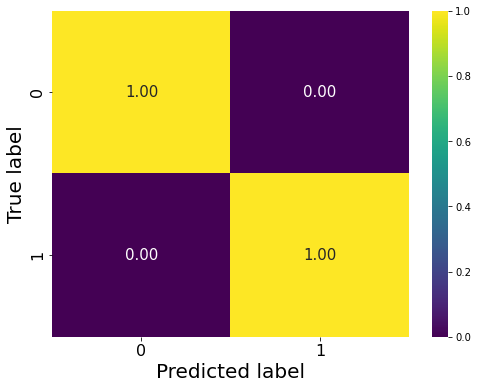

In [32]:
cm_drain_test = confusion_matrix(y_drain_test, best_estimator_drain.predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])

# _Doubly Robust Learning_: include `drain` as a feature into `model_y`.
- In doubly robust estimators of ATEs and CATES, the treatment variable is included in `model_y`

In [ ]:
y_full = csdh_doc['recurrence']
X_full = csdh_doc.drop(['recurrence'], axis=1)

In [ ]:
# Split into validation set and rest
X_rest, X_val, y_rest, y_val = train_test_split(X_full, y_full, 
                                                test_size=0.20,
                                                random_state=random_state,
                                                stratify=y_full)

# Split rest into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_rest, y_rest, 
                                                    test_size=0.20,
                                                    random_state=random_state,
                                                    stratify=y_rest)

In [ ]:
training_scores, val_scores = mmh.train_and_validate_classifiers(X_train, 
                                                                 y_train,
                                                                 X_val,
                                                                 y_val,
                                                                 names,
                                                                 classifiers)

In [ ]:
mmh.print_metrics_table(training_scores, val_scores, names)

In [ ]:
cm_test = confusion_matrix(y_test, classifiers[5].predict(X_test), normalize='true')
mmh.plot_confusion_matrix(cm_test, [0, 1])

## `model_y` K-Fold cross validation for hyperparameter tuning and model selection


In [ ]:
# do the search
_,_, best_estimator = mmh.randomized_search_cv(X_rest, y_rest, 
                                               search_space, 
                                               cv=cv_10,
                                               refit=True,
                                               score='roc_auc',
                                               n_iter=5000, 
                                               verbose=True)

In [ ]:
mmh.get_test_scores(X_rest, y_rest, X_test, y_test, best_estimator)

In [ ]:
cm_test = confusion_matrix(y_test, best_estimator.predict(X_test), normalize='true')
mmh.plot_confusion_matrix(cm_test, [0, 1])